In [2]:
#create a pandas dataframe with 100 rows and 10.000 columns
import pandas as pd
import numpy as np
import time

num_samples = 1000
num_proteins = 1000
df = pd.DataFrame(np.random.default_rng().normal(loc=100,scale= 3,size=(num_proteins, num_samples)), columns=list(range(num_samples)))
#create array of random integers of size num_samples
scaling_factors = np.random.default_rng().integers(low=10, high=1000, size=num_samples)

#add scaling factors to columns
for i in range(num_samples):
    df[i] = df[i] + scaling_factors[i]

mask = np.random.choice([0, 1], size=(num_proteins, num_samples), p=[0.5, 0.5])
#apply mask to df
df = df.mask(mask == 1)
display(df)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,755.479630,NaN,NaN,501.966223,NaN,771.863483,NaN,484.369536,771.426422,NaN,...,NaN,591.217314,945.152007,1032.975655,519.712971,1005.357133,NaN,NaN,NaN,NaN
1,754.497939,499.641210,407.979554,498.789289,188.510718,766.382820,240.096860,484.470711,770.253493,467.141707,...,NaN,591.156856,NaN,1032.167841,512.798001,1003.254200,NaN,NaN,904.796614,NaN
2,753.386569,492.810819,NaN,NaN,NaN,NaN,240.662571,485.086776,NaN,NaN,...,NaN,586.321033,NaN,NaN,515.113215,NaN,NaN,1076.199712,904.661979,NaN
3,755.816987,NaN,409.952477,NaN,NaN,766.152249,NaN,489.117760,759.912407,NaN,...,NaN,NaN,NaN,NaN,516.294988,NaN,159.829068,1078.475659,NaN,NaN
4,755.653440,501.361443,NaN,496.111139,184.029435,NaN,NaN,484.944744,NaN,NaN,...,418.912525,592.622390,NaN,1037.622770,513.845669,997.982253,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,NaN,407.445184,NaN,182.813606,NaN,236.468831,NaN,769.258969,NaN,...,412.781869,NaN,NaN,NaN,NaN,NaN,160.836504,NaN,902.677655,971.561471
996,NaN,NaN,403.171328,498.600607,NaN,NaN,243.603666,483.587025,NaN,472.680232,...,415.863049,588.807655,939.863528,NaN,513.526812,NaN,NaN,1080.870436,NaN,NaN
997,754.788437,NaN,NaN,504.226149,NaN,772.333679,NaN,NaN,770.914517,NaN,...,413.287759,NaN,940.703618,NaN,NaN,1003.473296,156.229472,1073.541914,NaN,972.269660
998,NaN,NaN,407.051948,NaN,183.047431,NaN,247.170107,NaN,NaN,NaN,...,NaN,590.924910,940.716496,1036.236710,NaN,997.851105,NaN,NaN,902.555386,968.799931


In [6]:
import directlfq.normalization

class NormalizationManagerSamplesOnSelectedProteinsDirectInput(directlfq.normalization.NormalizationManagerSamples):
    def __init__(self, complete_dataframe, num_samples_quadratic, selected_protein_groups):
        complete_dataframe = complete_dataframe.T #the samples to shift are in each row, therefore the df needs to be transposed
        self._selected_protein_groups = selected_protein_groups
        super().__init__(complete_dataframe, num_samples_quadratic)
        self.normalization_function = self._normalization_function
        self._run_normalization()
        self.complete_dataframe = complete_dataframe.T

    def _adapt_selected_proteins_to_protein_groups(self):
        if self._selected_proteins_file is not None:
            print('Normalizing only selected proteins')
            selected_proteins = pd.read_csv(self._selected_proteins_file, header=None, sep='\t')[0].to_list()
            protein2proteingroup_mapping = self._get_protein2proteingroup_mapping()
            existing_selected_proteins = [protein for protein in selected_proteins if protein in protein2proteingroup_mapping.keys()]
            self._selected_protein_groups = [protein2proteingroup_mapping[protein] for protein in existing_selected_proteins]

    def _get_protein2proteingroup_mapping(self):
        protein_groups = self.complete_dataframe.columns.get_level_values(0).to_list()
        protein2proteingroup_mapping = {protein : protein_group for protein_group in protein_groups for protein in protein_group.split(';')}
        return protein2proteingroup_mapping

    def _normalization_function(self, ion_dataframe):
        if self._selected_protein_groups is not None:
            ion_dataframe_selected = ion_dataframe.loc[:,self._selected_protein_groups]
        else:
            ion_dataframe_selected = ion_dataframe
        sample2shift = directlfq.normalization.get_normfacts(directlfq.normalization.drop_nas_if_possible(ion_dataframe_selected).to_numpy())
        df_c_normed = pd.DataFrame(directlfq.normalization.apply_sampleshifts(ion_dataframe.to_numpy(), sample2shift), index = ion_dataframe.index, columns = ion_dataframe.columns)
        return df_c_normed

    def _create_reference_sample(self):
        quadratic_subset_dataframe = self.complete_dataframe.loc[self._quadratic_subset_rows, self._selected_protein_groups]
        self._merged_reference_sample = quadratic_subset_dataframe.median(axis=0)

    def _shift_remaining_dataframe_to_reference_sample(self):
        linear_subset_dataframe = self.complete_dataframe.loc[self._linear_subset_rows]
        linear_shifted_dataframe = directlfq.normalization.SampleShifterLinear(linear_subset_dataframe, self._merged_reference_sample, protein_subset = self._selected_protein_groups).ion_dataframe
        self.complete_dataframe.loc[ self._linear_subset_rows, :] = linear_shifted_dataframe

    

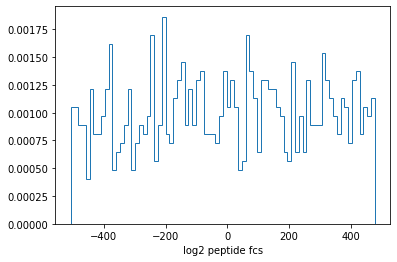

to few values for normalization without missing values. Including missing values


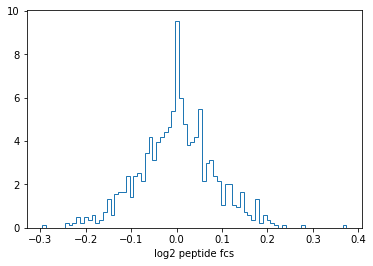

to few values for normalization without missing values. Including missing values
to few values for normalization without missing values. Including missing values


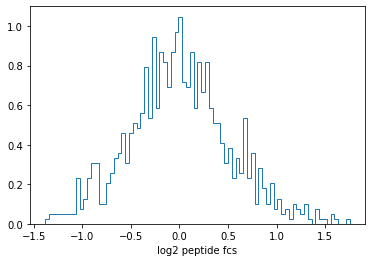

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,759.376304,NaN,NaN,761.143968,NaN,762.707450,NaN,759.268052,761.863566,NaN,...,NaN,759.606838,761.569915,758.547459,763.442250,763.117175,NaN,NaN,NaN,NaN
1,758.720113,763.093570,759.714375,758.292534,763.645154,757.552286,757.499400,759.694727,761.016137,754.267565,...,NaN,759.871880,NaN,758.065145,756.852780,761.339742,NaN,NaN,761.437487,NaN
2,758.109251,756.763687,NaN,NaN,NaN,NaN,758.565618,760.811300,NaN,NaN,...,NaN,755.536564,NaN,NaN,759.668502,NaN,NaN,759.134732,761.803360,NaN
3,760.348346,NaN,761.996483,NaN,NaN,757.630900,NaN,764.650961,750.984237,NaN,...,NaN,NaN,NaN,NaN,760.658952,NaN,762.666716,761.219356,NaN,NaN
4,760.859082,765.797272,NaN,756.597853,760.147339,NaN,NaN,761.152229,NaN,NaN,...,765.034207,762.320882,NaN,764.503542,758.883917,757.051263,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,NaN,760.318354,NaN,759.086391,NaN,755.009719,NaN,761.159962,NaN,...,759.058432,NaN,NaN,NaN,NaN,NaN,764.503316,NaN,760.456877,760.648216
996,NaN,NaN,755.860808,759.058512,NaN,NaN,761.960864,759.765700,NaN,760.760749,...,761.955921,758.477337,757.561595,NaN,758.536250,NaN,NaN,764.259607,NaN,NaN
997,759.143039,NaN,NaN,763.861823,NaN,763.635573,NaN,NaN,761.809589,NaN,...,758.558400,NaN,757.579454,NaN,NaN,761.691266,758.890363,756.108854,NaN,760.350483
998,NaN,NaN,759.770903,NaN,759.166001,NaN,765.556781,NaN,NaN,NaN,...,NaN,760.624067,758.444038,763.118148,NaN,756.920781,NaN,NaN,760.180392,757.732460


In [7]:
import directlfq.normalization
import directlfq.utils as lfq_utils
import random

def visualize_normalization_steps(df_to_normalize):
    lfq_utils.plot_relative_to_median_fcs(df_to_normalize)
    input_df_normalized = directlfq.normalization.NormalizationManagerSamples(df_to_normalize.copy(), num_samples_quadratic=50).complete_dataframe
    lfq_utils.plot_relative_to_median_fcs(input_df_normalized)

    #randomly select 100 items from a list
    selected_protein_groups = random.sample(list(df_to_normalize.index), 100)
    input_df_normalized_selected_proteins = NormalizationManagerSamplesOnSelectedProteinsDirectInput(df_to_normalize.copy(), num_samples_quadratic=50, selected_protein_groups=selected_protein_groups).complete_dataframe
    lfq_utils.plot_relative_to_median_fcs(input_df_normalized_selected_proteins)
    display(input_df_normalized_selected_proteins)


visualize_normalization_steps(df)